In [797]:
import pandas as pd
import numpy as np

df = pd.read_csv("finalNNDSS_new_1214.csv")
print('Disease Groups:')
print(df['Disease_group'].unique())

Disease Groups:
['Anthrax' 'Arboviral diseases' 'Candida auris' 'Hepatitis' 'Influenza'
 'Measles' 'Tuberculosis' 'Viral hemorrhagic fevers' 'Zika virus disease']


In [798]:
print('Features:')
print(df.columns)

Features:
Index(['Disease_group', 'Reporting Area norm', 'Current MMWR Year',
       'MMWR WEEK', 'Current week', 'current_week_reported', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_8', 'lag_12', 'lag_16', 'roll_mean_4',
       'roll_mean_8', 'roll_std_4', 'roll_std_8', 'growth_1', 'growth_4',
       'pct_change_1', 'pct_change_4', 'year', 'week', 'week_start_date',
       'month', 'quarter', 'day_of_year', 'season_winter', 'season_spring',
       'season_summer', 'season_fall', 'neighbor_cases_sum',
       'neighbor_cases_mean', 'neighbor_cases_max',
       'neighbor_states_reporting', 'log_population', 'log_density'],
      dtype='object')


In [799]:
df_flu = df[df["Disease_group"] == "Influenza"].copy()
df_flu = df_flu.sort_values(["Reporting Area norm", "year", "week"])
df_flu = df_flu.dropna()
df_flu = df_flu.reset_index(drop=True)
df_flu

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Influenza,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Influenza,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Influenza,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Influenza,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Influenza,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Influenza,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Influenza,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Influenza,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Influenza,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


Total state-weeks: 9024
Positive state-weeks: 164
Percent positive: 1.817%


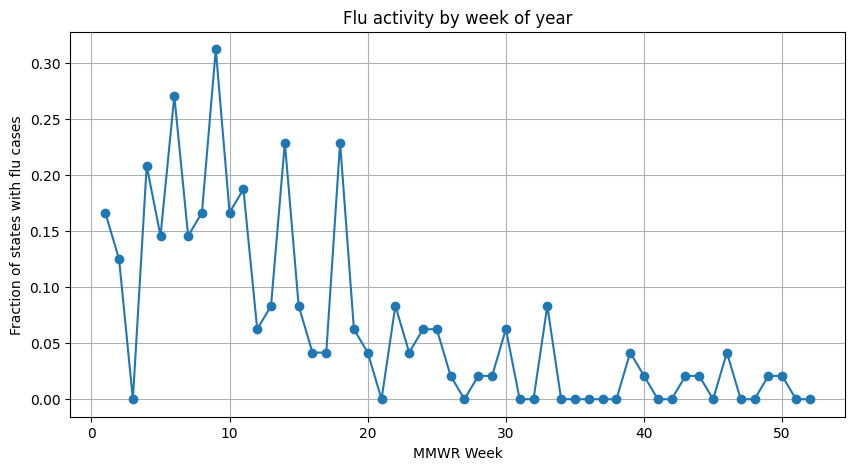

In [800]:
import matplotlib.pyplot as plt

total_rows = len(df_flu)
positive_rows = df_flu["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

weekly_pos = (
    df_flu
    .groupby("MMWR WEEK")["current_week_reported"]
    .sum()
    .reset_index(name="num_positive_states")
)

weekly_pos["percent_states_positive"] = (
    weekly_pos["num_positive_states"] /
    df_flu["Reporting Area norm"].nunique()
)

plt.figure(figsize=(10,5))
plt.plot(
    weekly_pos["MMWR WEEK"],
    weekly_pos["percent_states_positive"],
    marker="o"
)
plt.xlabel("MMWR Week")
plt.ylabel("Fraction of states with flu cases")
plt.title("Flu activity by week of year")
plt.grid(True)
plt.show()

In [801]:
# Create per-state time index
df_flu["t_idx"] = df_flu.groupby("Reporting Area norm").cumcount()
df_flu["t_len"] = df_flu.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_flu["is_train"] = df_flu["t_idx"] < (0.8 * df_flu["t_len"])

train_df = df_flu[df_flu["is_train"]].copy()
test_df  = df_flu[~df_flu["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [802]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * 1000

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 138 neg: 7110 scale_pos_weight: 51521.739130434784


Accuracy: 0.6942567567567568, Precision: 0.9810360106934174, Recall: 0.6942567567567568, F1: 0.8061523750927463


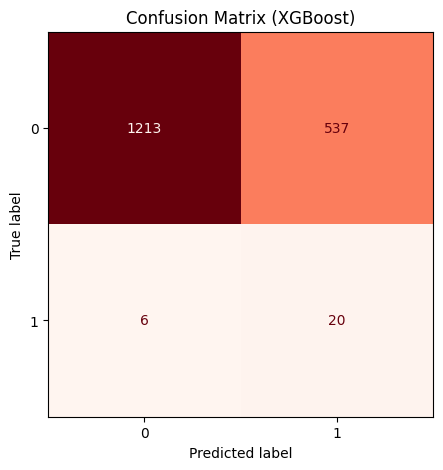

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.69      0.82      1750
           1       0.04      0.77      0.07        26

    accuracy                           0.69      1776
   macro avg       0.52      0.73      0.44      1776
weighted avg       0.98      0.69      0.81      1776



In [803]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.010
Balanced Acc: 0.7905
Recall(1) / TPR: 0.8462
Recall(0) / TNR: 0.7349
Accuracy: 0.7364864864864865, Precision: 0.9829676791347763, Recall: 0.6942567567567568, F1: 0.8349248199679943


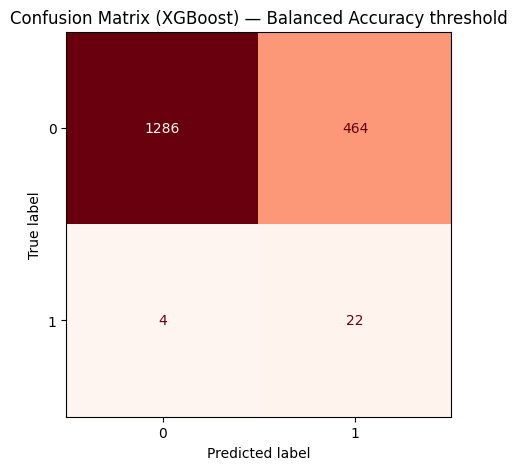

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      1750
           1       0.05      0.85      0.09        26

    accuracy                           0.74      1776
   macro avg       0.52      0.79      0.47      1776
weighted avg       0.98      0.74      0.83      1776



In [804]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.8316441441441441, Precision: 0.9822546781307501, Recall: 0.8316441441441441, F1: 0.8953906622221737


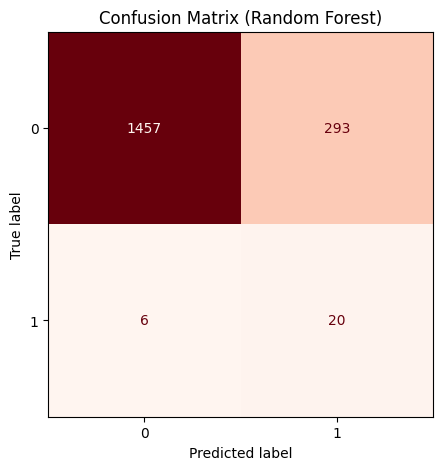

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1750
           1       0.06      0.77      0.12        26

    accuracy                           0.83      1776
   macro avg       0.53      0.80      0.51      1776
weighted avg       0.98      0.83      0.90      1776



In [805]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos) * 2}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [806]:
# Regression models -> only on cases with positive reporting

df_flu_lin = df_flu.copy()
df_flu_lin = df_flu_lin[df_flu_lin["Current week"] > 0].copy()
df_flu_lin = df_flu_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_flu_lin["t_idx"] = df_flu_lin.groupby("Reporting Area norm").cumcount()
df_flu_lin["t_len"] = df_flu_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_flu_lin["is_train"] = df_flu_lin["t_idx"] < (0.8 * df_flu_lin["t_len"])

train_df = df_flu_lin[df_flu_lin["is_train"]].copy()
test_df  = df_flu_lin[~df_flu_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 0.7963
R²: -0.3960
RSS: 12.05
TSS: 8.63
ESS: 2.48


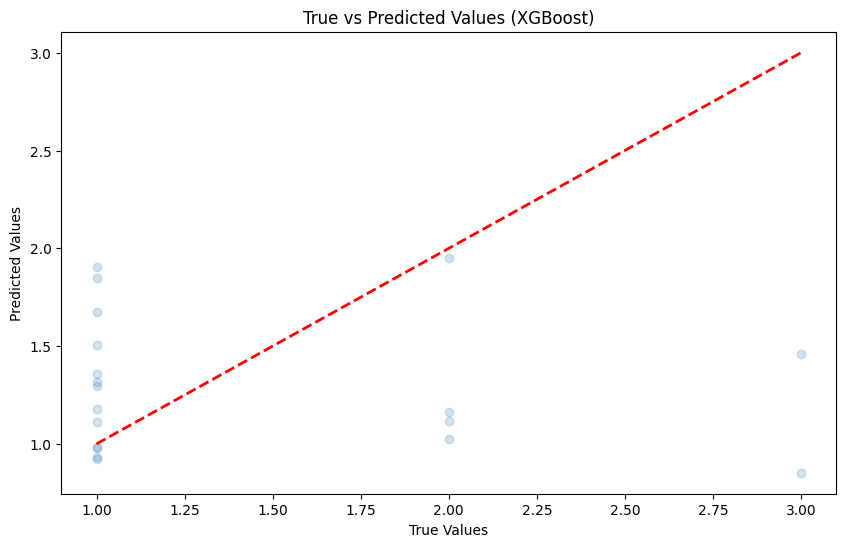

In [807]:
# XGBoost Regressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 0.7975
R²: -0.3999
RSS: 12.08
TSS: 8.63
ESS: 2.26


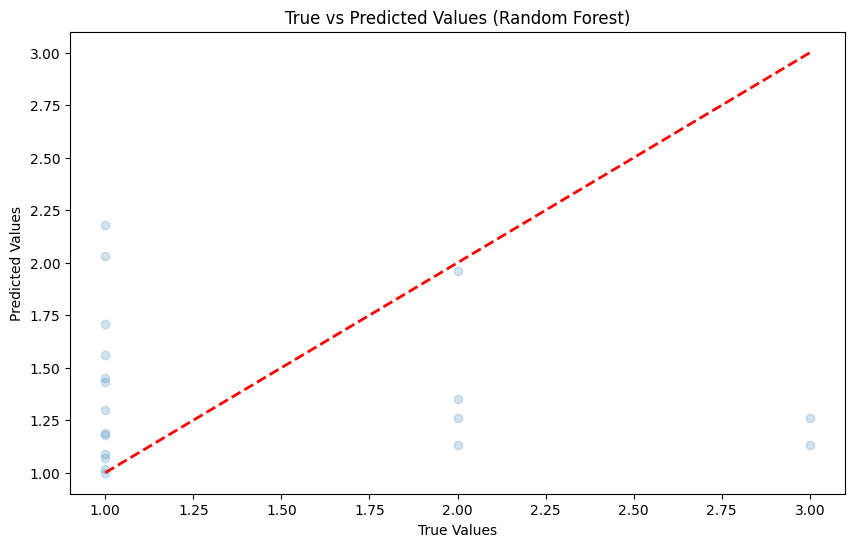

In [808]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

alpha= 0.1: MAE=1.387, RMSE=1.729
alpha= 0.5: MAE=1.324, RMSE=1.657
alpha= 1.0: MAE=1.305, RMSE=1.625
alpha= 2.0: MAE=1.285, RMSE=1.589
alpha= 5.0: MAE=1.263, RMSE=1.538
alpha=10.0: MAE=1.251, RMSE=1.504
RMSE: 0.7975
R²: -0.3999
RSS: 12.08
TSS: 8.63
ESS: 2.26


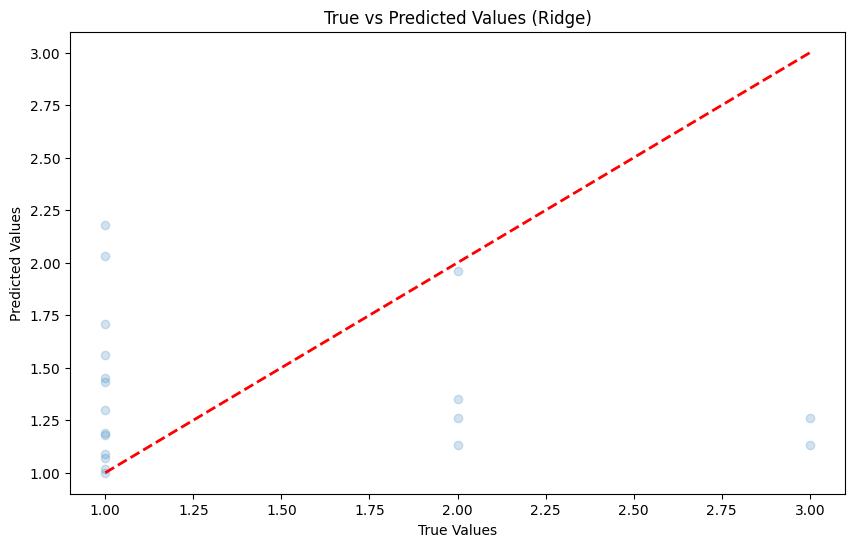

In [809]:
# Ridge Regressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

best_avg = 1000
best_alpha = -1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = (mae + rmse) / 2
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [810]:
# Measles
df_mea = df[df["Disease_group"] == "Measles"].copy()
df_mea = df_mea.sort_values(["Reporting Area norm", "year", "week"])
df_mea = df_mea.dropna()
df_mea = df_mea.reset_index(drop=True)
df_mea

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Measles,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Measles,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Measles,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Measles,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Measles,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Measles,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Measles,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Measles,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Measles,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


In [811]:
total_rows = len(df_mea)
positive_rows = df_mea["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 204
Percent positive: 2.261%


In [812]:
# Create per-state time index
df_mea["t_idx"] = df_mea.groupby("Reporting Area norm").cumcount()
df_mea["t_len"] = df_mea.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_mea["is_train"] = df_mea["t_idx"] < (0.9 * df_mea["t_len"])

train_df = df_mea[df_mea["is_train"]].copy()
test_df  = df_mea[~df_mea["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [813]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * 25

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 156 neg: 8004 scale_pos_weight: 1282.6923076923076


Accuracy: 0.8484, Precision: 0.9237, Recall: 0.8484, F1: 0.8795


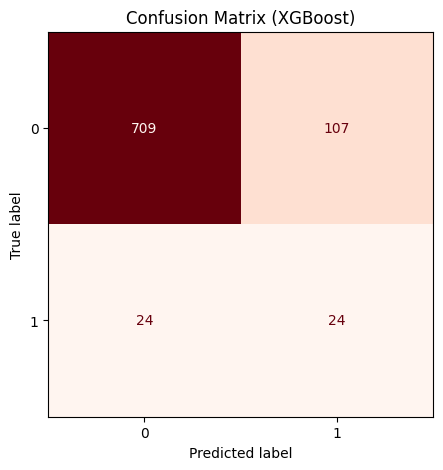

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       816
           1       0.18      0.50      0.27        48

    accuracy                           0.85       864
   macro avg       0.58      0.68      0.59       864
weighted avg       0.92      0.85      0.88       864



In [814]:
# Scale classifier to boost instances of reported cases
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.020
Balanced Acc: 0.8009
Recall(1) / TPR: 0.7083
Recall(0) / TNR: 0.8934
Accuracy: 0.8831, Precision: 0.9423, Recall: 0.8484, F1: 0.9056


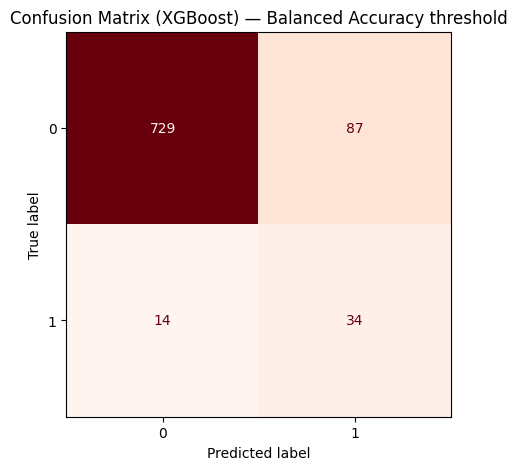

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.94       816
           1       0.28      0.71      0.40        48

    accuracy                           0.88       864
   macro avg       0.63      0.80      0.67       864
weighted avg       0.94      0.88      0.91       864



In [815]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.8333333333333334, Precision: 0.902780933339392, Recall: 0.8333333333333334, F1: 0.8647393671999137


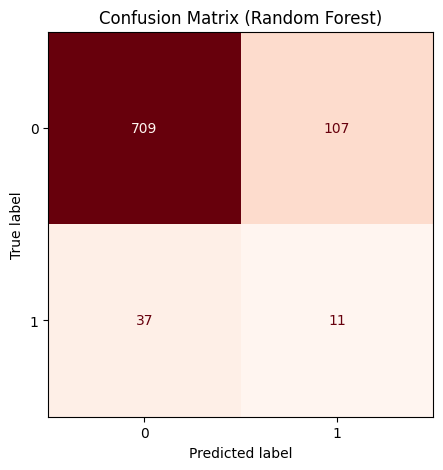

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       816
           1       0.09      0.23      0.13        48

    accuracy                           0.83       864
   macro avg       0.52      0.55      0.52       864
weighted avg       0.90      0.83      0.86       864



In [816]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos) * 10}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [817]:
# Regression models -> only on cases with positive reporting

df_mea_lin = df_mea.copy()
df_mea_lin = df_mea_lin[df_mea_lin["Current week"] > 0].copy()
df_mea_lin = df_mea_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_mea_lin["t_idx"] = df_mea_lin.groupby("Reporting Area norm").cumcount()
df_mea_lin["t_len"] = df_mea_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_mea_lin["is_train"] = df_mea_lin["t_idx"] < (0.8 * df_mea_lin["t_len"])

train_df = df_mea_lin[df_mea_lin["is_train"]].copy()
test_df  = df_mea_lin[~df_mea_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 3.7053
R²: -0.0116
RSS: 425.61
TSS: 420.71
ESS: 86.80


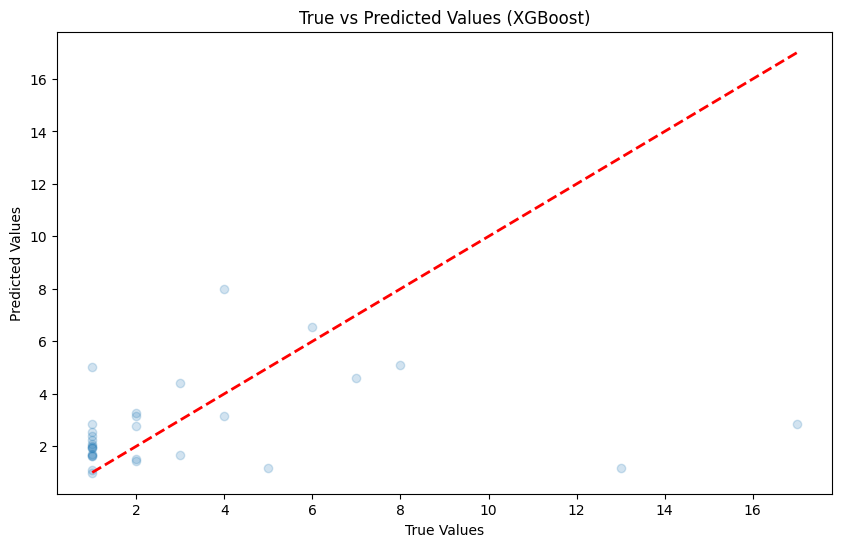

In [818]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 3.3197
R²: 0.1880
RSS: 341.63
TSS: 420.71
ESS: 69.08


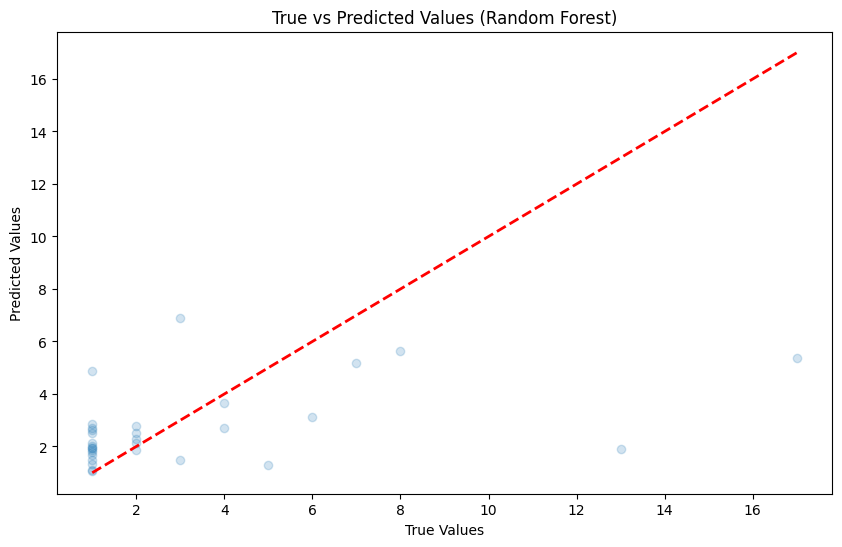

In [819]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

alpha= 0.1: MAE=265.932, RMSE=1329.160
alpha= 0.5: MAE=172.183, RMSE=796.063
alpha= 1.0: MAE=126.033, RMSE=521.493
alpha= 2.0: MAE=90.831, RMSE=301.850
alpha= 5.0: MAE=76.843, RMSE=160.945
alpha=10.0: MAE=97.749, RMSE=231.974
RMSE: 3.3197
R²: 0.1880
RSS: 341.63
TSS: 420.71
ESS: 69.08


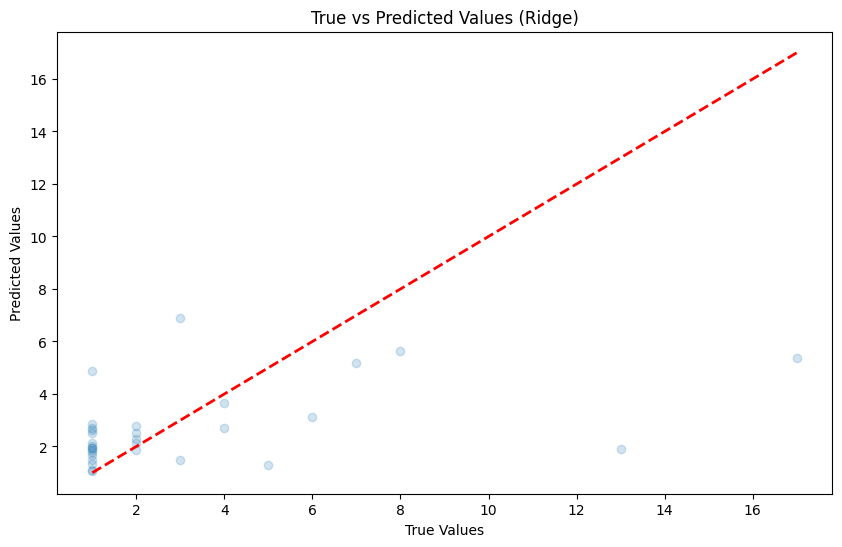

In [820]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

best_avg = 1000
best_alpha = -1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = (mae + rmse) / 2
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [821]:
# Anthrax
df_ant = df[df["Disease_group"] == "Anthrax"].copy()
df_ant = df_ant.sort_values(["Reporting Area norm", "year", "week"])
df_ant = df_ant.dropna()
df_ant = df_ant.reset_index(drop=True)
df_ant

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Anthrax,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Anthrax,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Anthrax,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Anthrax,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Anthrax,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Anthrax,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Anthrax,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Anthrax,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Anthrax,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


In [822]:
total_rows = len(df_ant)
positive_rows = df_ant["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

# No positive cases of anthrax in mainland US

Total state-weeks: 9024
Positive state-weeks: 0
Percent positive: 0.000%


In [823]:
# Arboviral diseases
df_arb = df[df["Disease_group"] == "Arboviral diseases"].copy()
df_arb = df_arb.sort_values(["Reporting Area norm", "year", "week"])
df_arb = df_arb.dropna()
df_arb = df_arb.reset_index(drop=True)
df_arb

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Arboviral diseases,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Arboviral diseases,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Arboviral diseases,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Arboviral diseases,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Arboviral diseases,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Arboviral diseases,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Arboviral diseases,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Arboviral diseases,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Arboviral diseases,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


In [824]:
total_rows = len(df_arb)
positive_rows = df_arb["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 339
Percent positive: 3.757%


In [825]:
# Create per-state time index
df_arb["t_idx"] = df_arb.groupby("Reporting Area norm").cumcount()
df_arb["t_len"] = df_arb.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_arb["is_train"] = df_arb["t_idx"] < (0.8 * df_arb["t_len"])

train_df = df_arb[df_arb["is_train"]].copy()
test_df  = df_arb[~df_arb["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [826]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * 1

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 231 neg: 7017 scale_pos_weight: 30.376623376623378


Accuracy: 0.8851, Precision: 0.9429, Recall: 0.8851, F1: 0.9063


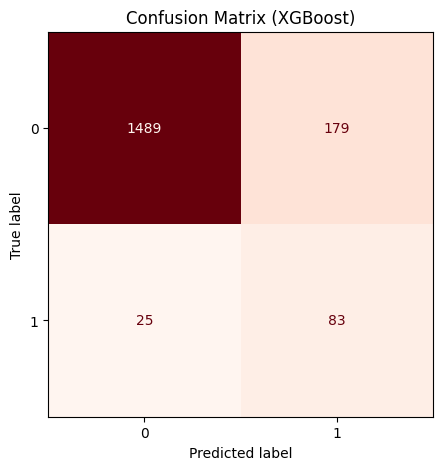

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.94      1668
           1       0.32      0.77      0.45       108

    accuracy                           0.89      1776
   macro avg       0.65      0.83      0.69      1776
weighted avg       0.94      0.89      0.91      1776



In [827]:
# Scale classifier to boost instances of reported cases
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.040
Balanced Acc: 0.8745
Recall(1) / TPR: 0.8611
Recall(0) / TNR: 0.8879
Accuracy: 0.8863, Precision: 0.9500, Recall: 0.8851, F1: 0.9084


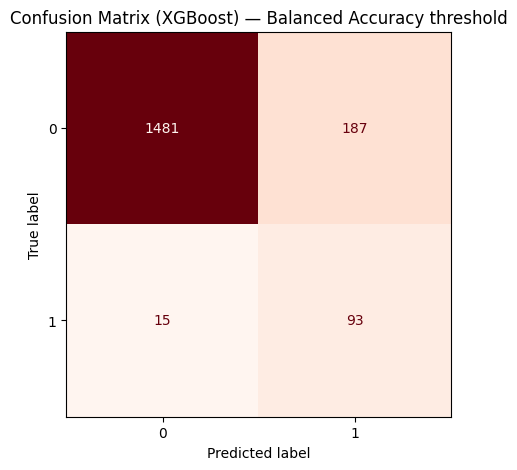

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1668
           1       0.33      0.86      0.48       108

    accuracy                           0.89      1776
   macro avg       0.66      0.87      0.71      1776
weighted avg       0.95      0.89      0.91      1776



In [828]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.9149774774774775, Precision: 0.9496359718373182, Recall: 0.9149774774774775, F1: 0.9275015129153051


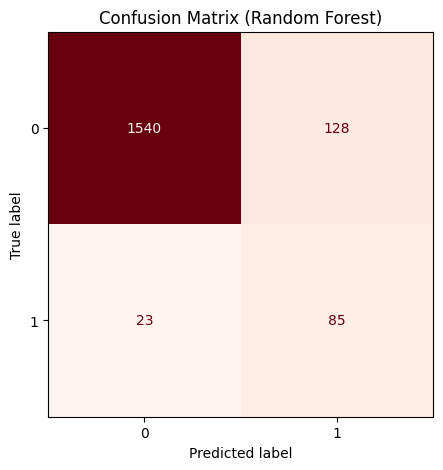

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1668
           1       0.40      0.79      0.53       108

    accuracy                           0.91      1776
   macro avg       0.69      0.86      0.74      1776
weighted avg       0.95      0.91      0.93      1776



In [829]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos)}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [830]:
# Regression models -> only on cases with positive reporting

df_arb_lin = df_arb.copy()
df_arb_lin = df_arb_lin[df_arb_lin["Current week"] > 0].copy()
df_arb_lin = df_arb_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_arb_lin["t_idx"] = df_arb_lin.groupby("Reporting Area norm").cumcount()
df_arb_lin["t_len"] = df_arb_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_arb_lin["is_train"] = df_arb_lin["t_idx"] < (0.8 * df_arb_lin["t_len"])

train_df = df_arb_lin[df_arb_lin["is_train"]].copy()
test_df  = df_arb_lin[~df_arb_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 4.0832
R²: 0.2352
RSS: 967.02
TSS: 1264.48
ESS: 106.59


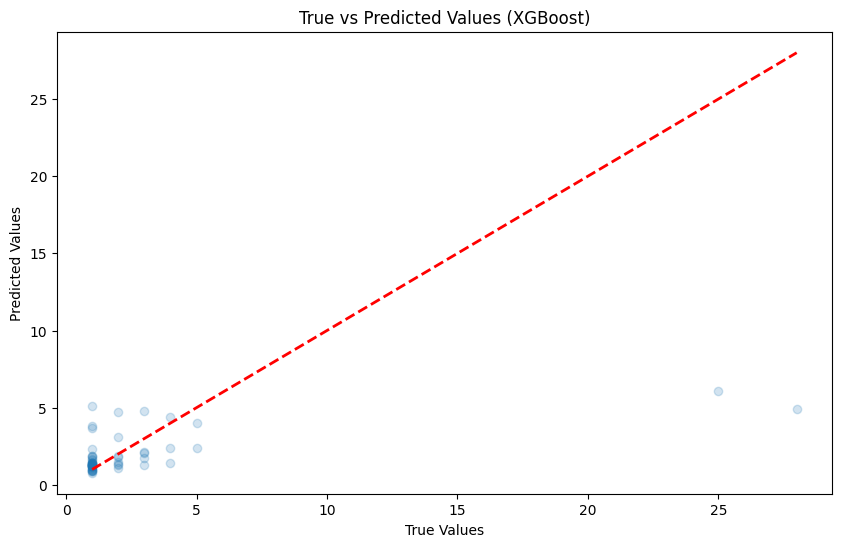

In [831]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 3.9882
R²: 0.2704
RSS: 922.51
TSS: 1264.48
ESS: 106.05


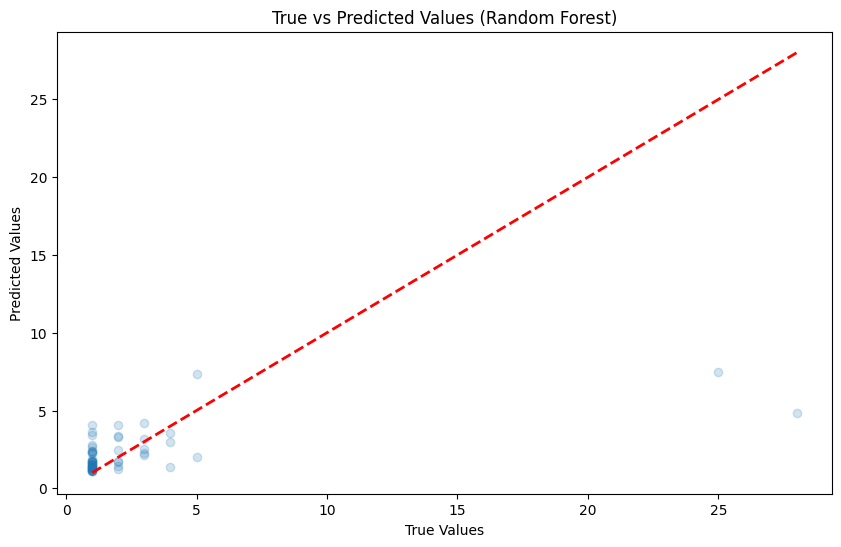

In [832]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

alpha= 0.1: MAE=3865.809, RMSE=28801.561
alpha= 0.5: MAE=3844.131, RMSE=28652.131
alpha= 1.0: MAE=4034.444, RMSE=30091.036
alpha= 2.0: MAE=4342.826, RMSE=32410.043
alpha= 5.0: MAE=4852.043, RMSE=36181.858
alpha=10.0: MAE=5182.247, RMSE=38500.193
RMSE: 3.9882
R²: 0.2704
RSS: 922.51
TSS: 1264.48
ESS: 106.05


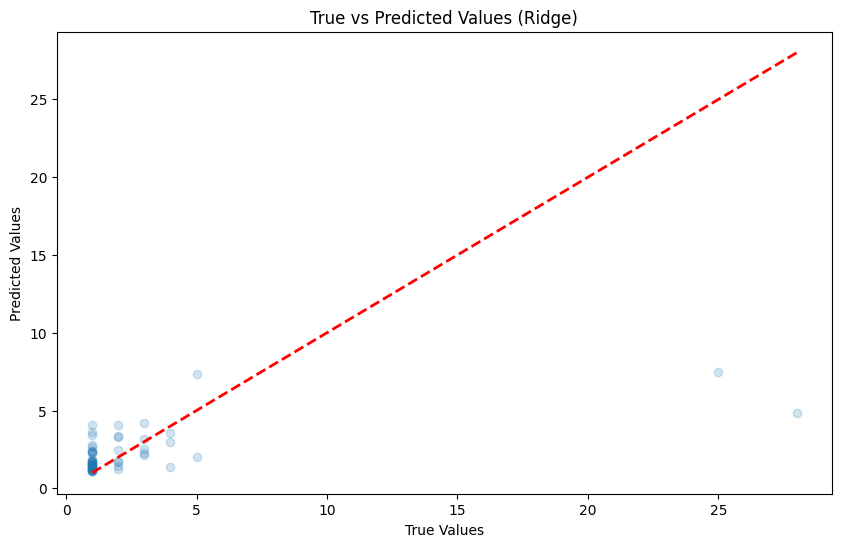

In [833]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

best_avg = 100000
best_alpha = -1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = (mae + rmse) / 2
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [834]:
# Candida auris
df_can = df[df["Disease_group"] == "Candida auris"].copy()
df_can = df_can.sort_values(["Reporting Area norm", "year", "week"])
df_can = df_can.dropna()
df_can = df_can.reset_index(drop=True)
df_can

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Candida auris,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Candida auris,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Candida auris,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Candida auris,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Candida auris,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Candida auris,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Candida auris,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Candida auris,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Candida auris,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


In [835]:
total_rows = len(df_can)
positive_rows = df_can["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 1307
Percent positive: 14.484%


In [836]:
# Create per-state time index
df_can["t_idx"] = df_can.groupby("Reporting Area norm").cumcount()
df_can["t_len"] = df_can.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_can["is_train"] = df_can["t_idx"] < (0.8 * df_can["t_len"])

train_df = df_can[df_can["is_train"]].copy()
test_df  = df_can[~df_can["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [837]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * .5

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 924 neg: 6324 scale_pos_weight: 3.4220779220779223


Accuracy: 0.9313, Precision: 0.9303, Recall: 0.9313, F1: 0.9306


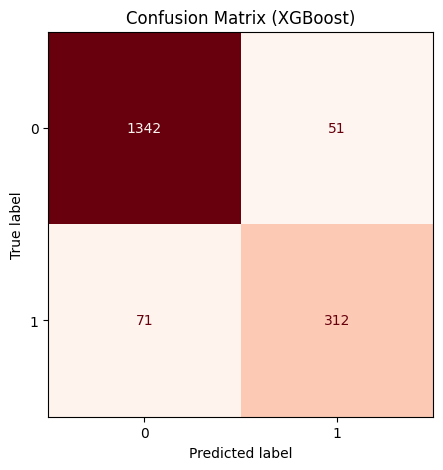

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1393
           1       0.86      0.81      0.84       383

    accuracy                           0.93      1776
   macro avg       0.90      0.89      0.90      1776
weighted avg       0.93      0.93      0.93      1776



In [838]:
# Scale classifier to boost instances of reported cases -> don't need to scale
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    #scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.140
Balanced Acc: 0.9224
Recall(1) / TPR: 0.9373
Recall(0) / TNR: 0.9074
Accuracy: 0.9139, Precision: 0.9284, Recall: 0.9313, F1: 0.9174


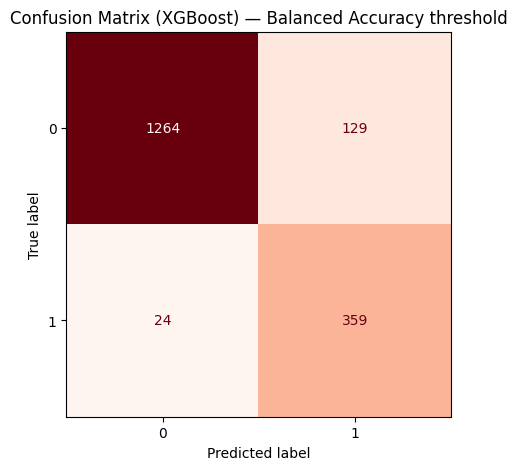

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1393
           1       0.74      0.94      0.82       383

    accuracy                           0.91      1776
   macro avg       0.86      0.92      0.88      1776
weighted avg       0.93      0.91      0.92      1776



In [839]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.9183558558558559, Precision: 0.9314743419578936, Recall: 0.9183558558558559, F1: 0.9215239263628425


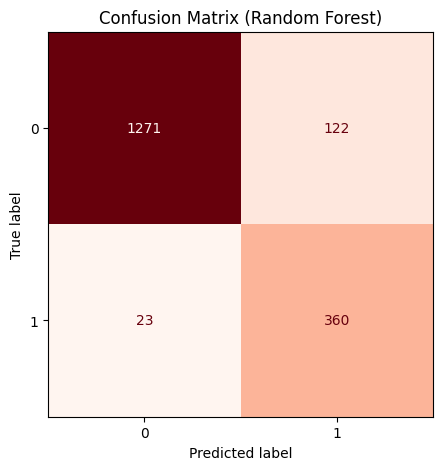

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1393
           1       0.75      0.94      0.83       383

    accuracy                           0.92      1776
   macro avg       0.86      0.93      0.89      1776
weighted avg       0.93      0.92      0.92      1776



In [840]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos)}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [841]:
# Regression models -> all cases, there is enough support now

df_can_lin = df_can.copy()
df_can_lin = df_can_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_can_lin["t_idx"] = df_can_lin.groupby("Reporting Area norm").cumcount()
df_can_lin["t_len"] = df_can_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_can_lin["is_train"] = df_can_lin["t_idx"] < (0.8 * df_can_lin["t_len"])

train_df = df_can_lin[df_can_lin["is_train"]].copy()
test_df  = df_can_lin[~df_can_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 4.2189
R²: 0.5209
RSS: 31611.84
TSS: 65976.59
ESS: 32974.79


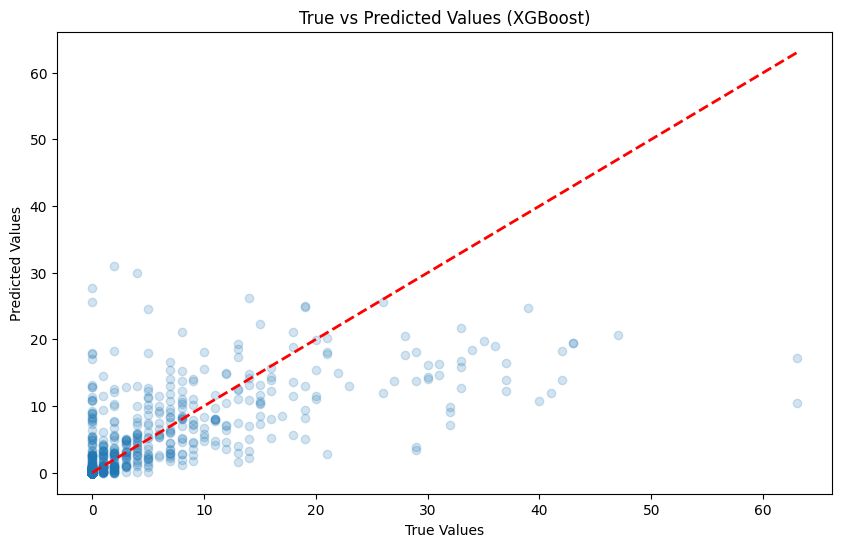

In [842]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 3.9146
R²: 0.5875
RSS: 27216.00
TSS: 65976.59
ESS: 34696.95


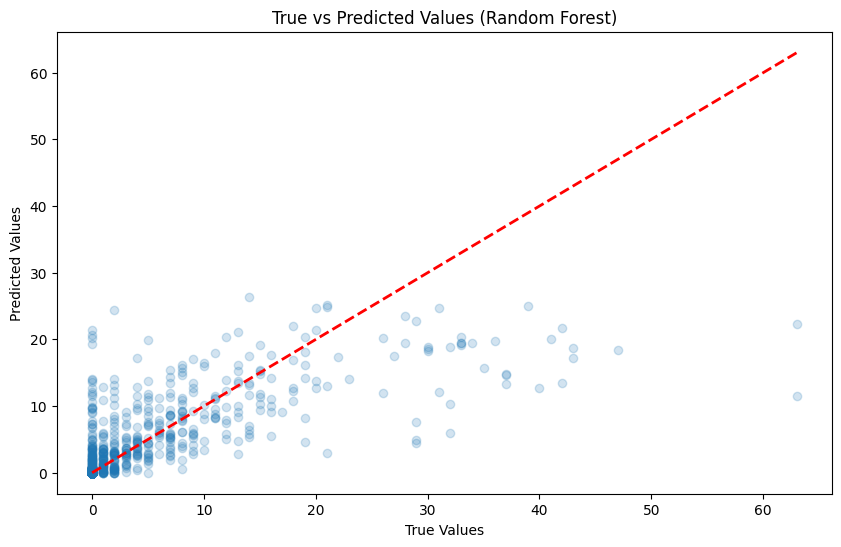

In [843]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

alpha= 0.1: MAE=1098898132297540.000, RMSE=46069940096215728.000
alpha= 0.5: MAE=1091003588654577.625, RMSE=45733610631745136.000
alpha= 1.0: MAE=1081294099290877.750, RMSE=45320234845883280.000
alpha= 2.0: MAE=1062374111715224.875, RMSE=44515590765573288.000
alpha= 5.0: MAE=1009166662502523.125, RMSE=42258551504235600.000
alpha=10.0: MAE=930339198674162.250, RMSE=38928321102829560.000
RMSE: 3.9146
R²: 0.5875
RSS: 27216.00
TSS: 65976.59
ESS: 34696.95


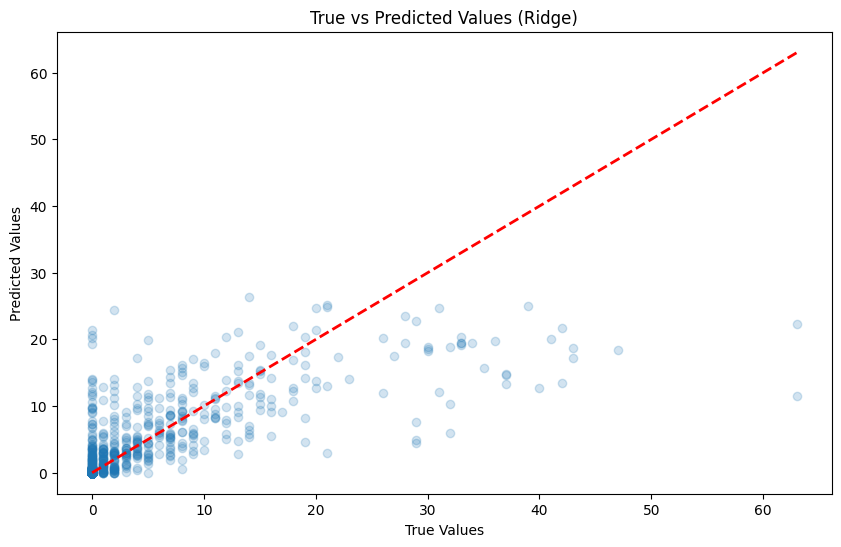

In [844]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

best_avg = 10000000000000000000
best_alpha = -1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = (mae + rmse) / 2
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [845]:
# Hepatitis
df_hep = df[df["Disease_group"] == "Hepatitis"].copy()
df_hep = df_hep.sort_values(["Reporting Area norm", "year", "week"])
df_hep = df_hep.dropna()
df_hep = df_hep.reset_index(drop=True)
df_hep

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Hepatitis,Alabama,2022,17,0.0,0,2.0,0.0,0.0,1.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Hepatitis,Alabama,2022,18,0.0,0,0.0,2.0,0.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Hepatitis,Alabama,2022,19,1.0,1,0.0,0.0,2.0,0.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Hepatitis,Alabama,2022,20,0.0,0,1.0,0.0,0.0,2.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Hepatitis,Alabama,2022,21,0.0,0,0.0,1.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Hepatitis,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Hepatitis,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Hepatitis,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Hepatitis,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


In [846]:
total_rows = len(df_hep)
positive_rows = df_hep["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 4638
Percent positive: 51.396%


In [847]:
# Create per-state time index
df_hep["t_idx"] = df_hep.groupby("Reporting Area norm").cumcount()
df_hep["t_len"] = df_hep.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_hep["is_train"] = df_hep["t_idx"] < (0.8 * df_hep["t_len"])

train_df = df_hep[df_hep["is_train"]].copy()
test_df  = df_hep[~df_hep["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [848]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * .5

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 3461 neg: 3787 scale_pos_weight: 0.5470962149667726


Accuracy: 0.9088, Precision: 0.9089, Recall: 0.9088, F1: 0.9088


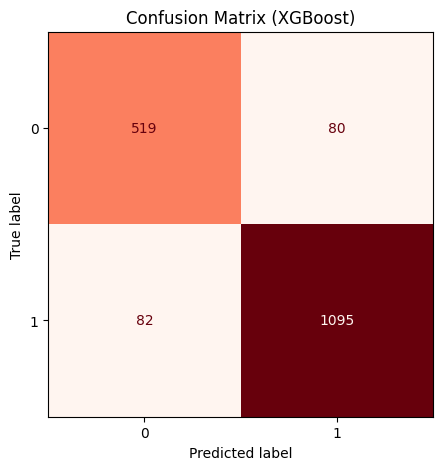

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       599
           1       0.93      0.93      0.93      1177

    accuracy                           0.91      1776
   macro avg       0.90      0.90      0.90      1776
weighted avg       0.91      0.91      0.91      1776



In [849]:
# Scale classifier to boost instances of reported cases -> don't need to scale
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    #scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.680
Balanced Acc: 0.9094
Recall(1) / TPR: 0.8989
Recall(0) / TNR: 0.9199
Accuracy: 0.9060, Precision: 0.9113, Recall: 0.9088, F1: 0.9071


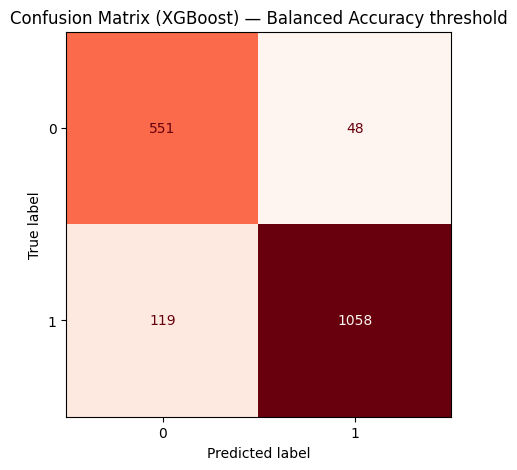

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       599
           1       0.96      0.90      0.93      1177

    accuracy                           0.91      1776
   macro avg       0.89      0.91      0.90      1776
weighted avg       0.91      0.91      0.91      1776



In [850]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.9048423423423423, Precision: 0.9042661566127361, Recall: 0.9048423423423423, F1: 0.9044141392655903


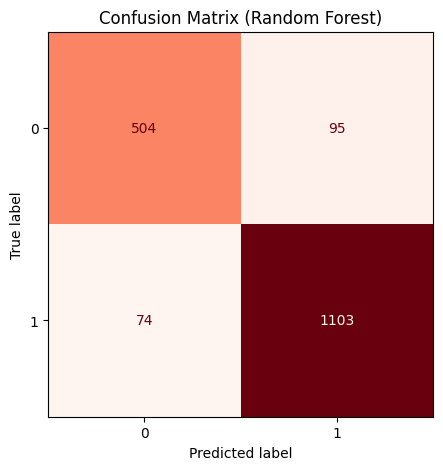

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       599
           1       0.92      0.94      0.93      1177

    accuracy                           0.90      1776
   macro avg       0.90      0.89      0.89      1776
weighted avg       0.90      0.90      0.90      1776



In [851]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    #class_weight={0: 1, 1: (neg / pos)}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [852]:
# Regression models -> all cases, there is enough support

df_hep_lin = df_hep.copy()
df_hep_lin = df_hep_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_hep_lin["t_idx"] = df_hep_lin.groupby("Reporting Area norm").cumcount()
df_hep_lin["t_len"] = df_hep_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_hep_lin["is_train"] = df_hep_lin["t_idx"] < (0.8 * df_hep_lin["t_len"])

train_df = df_hep_lin[df_hep_lin["is_train"]].copy()
test_df  = df_hep_lin[~df_hep_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 26.9717
R²: 0.8552
RSS: 1291992.21
TSS: 8919704.68
ESS: 7709249.62


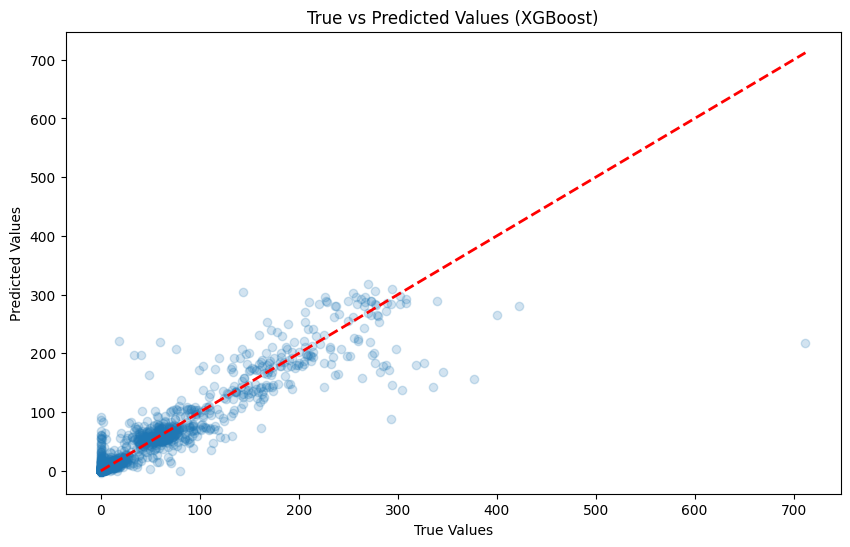

In [853]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 26.1681
R²: 0.8637
RSS: 1216152.10
TSS: 8919704.68
ESS: 7687794.59


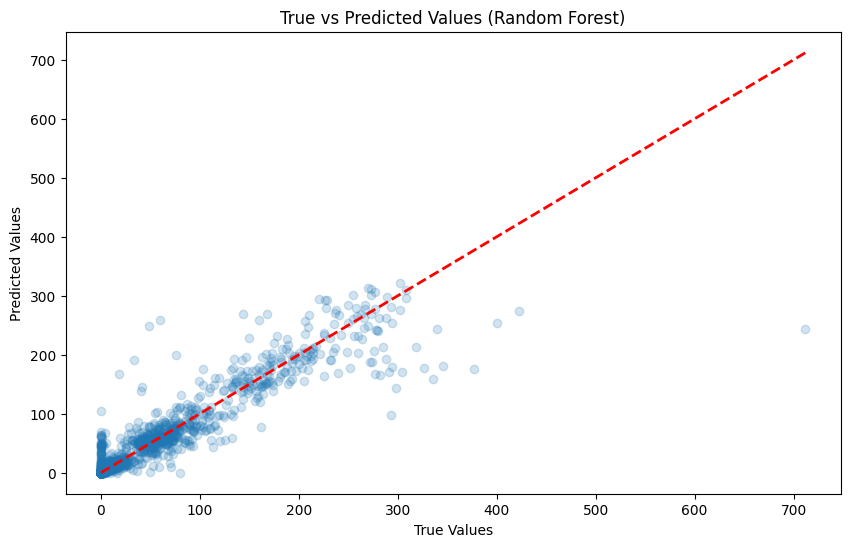

In [854]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0

alpha= 0.1: MAE=930339198674162.250, RMSE=inf
alpha= 0.5: MAE=930339198674162.250, RMSE=inf
alpha= 1.0: MAE=930339198674162.250, RMSE=inf
alpha= 2.0: MAE=930339198674162.250, RMSE=inf
alpha= 5.0: MAE=930339198674162.250, RMSE=inf
alpha=10.0: MAE=930339198674162.250, RMSE=inf
RMSE: 26.1681
R²: 0.8637
RSS: 1216152.10
TSS: 8919704.68
ESS: 7687794.59


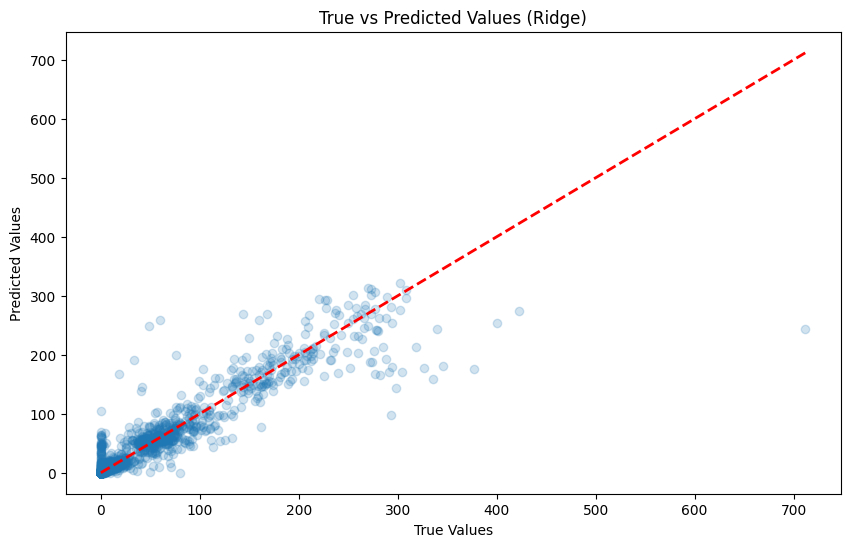

In [855]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

ridge = Ridge(alpha=0.1, random_state=42)
ridge.fit(X_train_s, y_train)
y_pred = np.expm1(ridge.predict(X_test_s))
rmse = sqrt(mean_squared_error(y_test, y_pred))
best_avg = rmse
best_alpha = 0.1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = rmse
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [856]:
# Tuberculosis
df_tub = df[df["Disease_group"] == "Tuberculosis"].copy()
df_tub = df_tub.sort_values(["Reporting Area norm", "year", "week"])
df_tub = df_tub.dropna()
df_tub = df_tub.reset_index(drop=True)
df_tub

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Tuberculosis,Alabama,2022,17,1.0,1,2.0,1.0,0.0,5.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Tuberculosis,Alabama,2022,18,1.0,1,1.0,2.0,1.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Tuberculosis,Alabama,2022,19,1.0,1,1.0,1.0,2.0,1.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Tuberculosis,Alabama,2022,20,0.0,0,1.0,1.0,1.0,2.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Tuberculosis,Alabama,2022,21,1.0,1,0.0,1.0,1.0,1.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Tuberculosis,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Tuberculosis,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Tuberculosis,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Tuberculosis,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


In [857]:
total_rows = len(df_tub)
positive_rows = df_tub["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 2430
Percent positive: 26.928%


In [858]:
# Create per-state time index
df_tub["t_idx"] = df_tub.groupby("Reporting Area norm").cumcount()
df_tub["t_len"] = df_tub.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_tub["is_train"] = df_tub["t_idx"] < (0.8 * df_tub["t_len"])

train_df = df_tub[df_tub["is_train"]].copy()
test_df  = df_tub[~df_tub["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [859]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * .75

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 1832 neg: 5416 scale_pos_weight: 2.217248908296943


Accuracy: 0.7973, Precision: 0.8056, Recall: 0.7973, F1: 0.8000


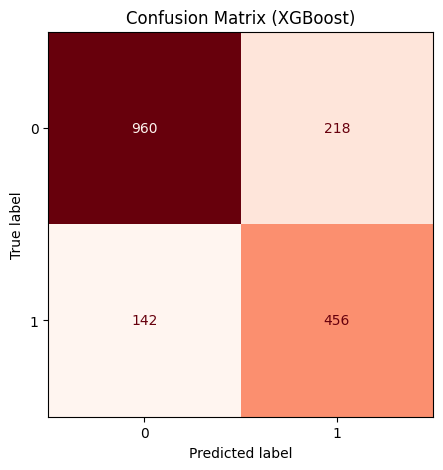

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1178
           1       0.68      0.76      0.72       598

    accuracy                           0.80      1776
   macro avg       0.77      0.79      0.78      1776
weighted avg       0.81      0.80      0.80      1776



In [860]:
# Scale classifier to boost instances of reported cases
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.340
Balanced Acc: 0.7876
Recall(1) / TPR: 0.7492
Recall(0) / TNR: 0.8260
Accuracy: 0.8001, Precision: 0.8057, Recall: 0.7973, F1: 0.8021


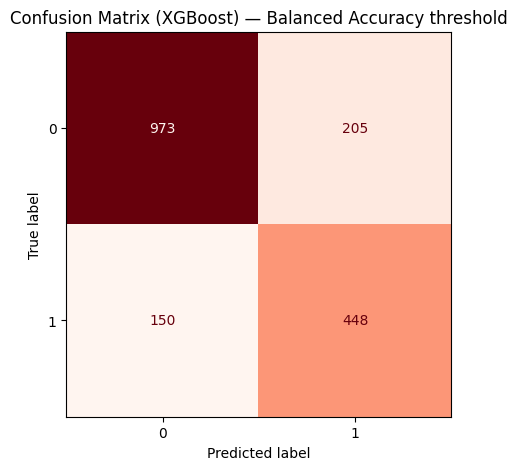

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1178
           1       0.69      0.75      0.72       598

    accuracy                           0.80      1776
   macro avg       0.78      0.79      0.78      1776
weighted avg       0.81      0.80      0.80      1776



In [861]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.8051801801801802, Precision: 0.8038566865216041, Recall: 0.8051801801801802, F1: 0.8044303190857616


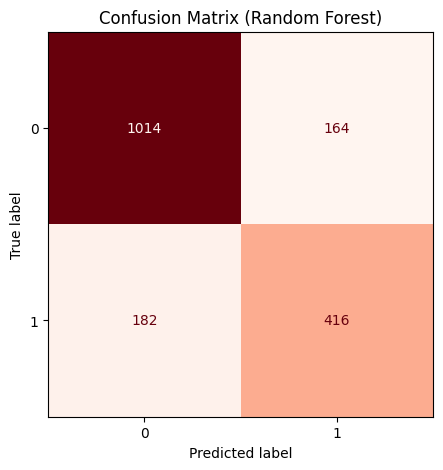

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1178
           1       0.72      0.70      0.71       598

    accuracy                           0.81      1776
   macro avg       0.78      0.78      0.78      1776
weighted avg       0.80      0.81      0.80      1776



In [862]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos) * .5}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [863]:
# Regression models -> all cases, there is enough support

df_tub_lin = df_tub.copy()
df_tub_lin = df_tub_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_tub_lin["t_idx"] = df_tub_lin.groupby("Reporting Area norm").cumcount()
df_tub_lin["t_len"] = df_tub_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_tub_lin["is_train"] = df_tub_lin["t_idx"] < (0.8 * df_tub_lin["t_len"])

train_df = df_tub_lin[df_tub_lin["is_train"]].copy()
test_df  = df_tub_lin[~df_tub_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 1.5301
R²: 0.3793
RSS: 4158.10
TSS: 6699.29
ESS: 2644.58


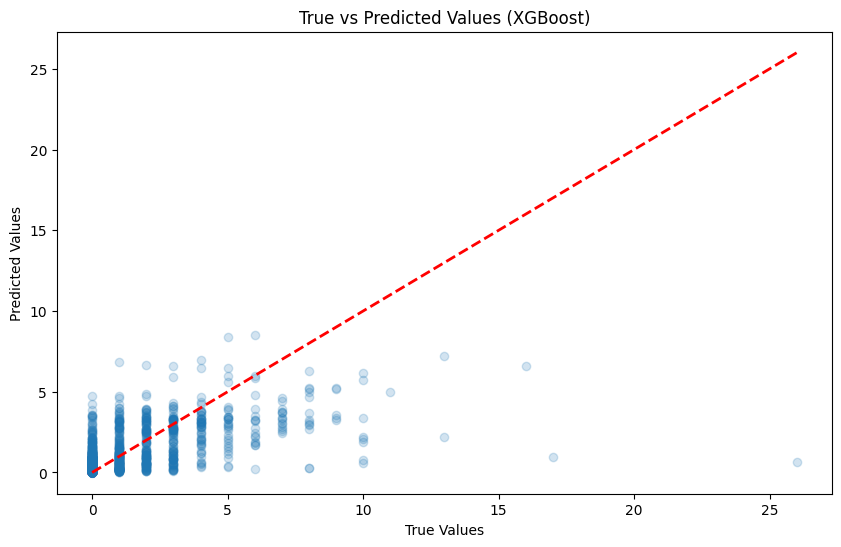

In [864]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 1.5067
R²: 0.3982
RSS: 4031.86
TSS: 6699.29
ESS: 2781.91


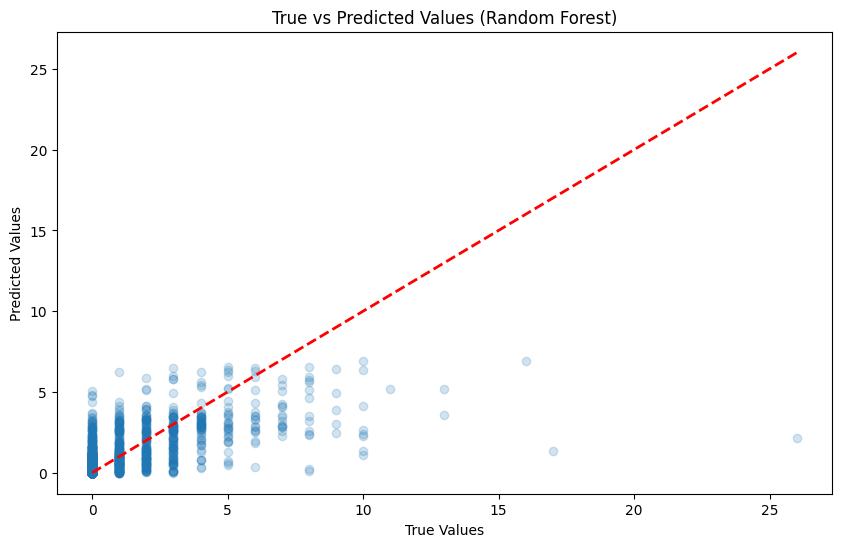

In [865]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

alpha= 0.1: MAE=930339198674162.250, RMSE=124.924
alpha= 0.5: MAE=930339198674162.250, RMSE=124.853
alpha= 1.0: MAE=930339198674162.250, RMSE=124.765
alpha= 2.0: MAE=930339198674162.250, RMSE=124.592
alpha= 5.0: MAE=930339198674162.250, RMSE=124.093
alpha=10.0: MAE=930339198674162.250, RMSE=123.313
RMSE: 1.5067
R²: 0.3982
RSS: 4031.86
TSS: 6699.29
ESS: 2781.91


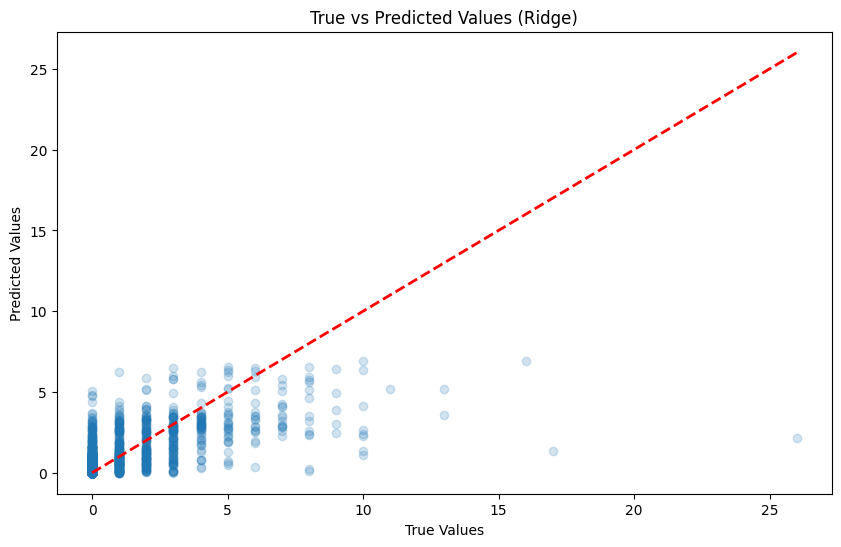

In [866]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

ridge = Ridge(alpha=0.1, random_state=42)
ridge.fit(X_train_s, y_train)
y_pred = np.expm1(ridge.predict(X_test_s))
rmse = sqrt(mean_squared_error(y_test, y_pred))
best_avg = rmse
best_alpha = 0.1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = rmse
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [867]:
# Viral hemorrhagic fevers
df_vir = df[df["Disease_group"] == 'Viral hemorrhagic fevers'].copy()
df_vir = df_vir.sort_values(["Reporting Area norm", "year", "week"])
df_vir = df_vir.dropna()
df_vir = df_vir.reset_index(drop=True)
df_vir

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Viral hemorrhagic fevers,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Viral hemorrhagic fevers,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Viral hemorrhagic fevers,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Viral hemorrhagic fevers,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Viral hemorrhagic fevers,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Viral hemorrhagic fevers,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Viral hemorrhagic fevers,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Viral hemorrhagic fevers,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Viral hemorrhagic fevers,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


In [868]:
total_rows = len(df_vir)
positive_rows = df_vir["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

# No positive viral hemorrhagic fevers move on

Total state-weeks: 9024
Positive state-weeks: 0
Percent positive: 0.000%


In [869]:
# Zika virus disease
df_zik = df[df["Disease_group"] == 'Zika virus disease'].copy()
df_zik = df_zik.sort_values(["Reporting Area norm", "year", "week"])
df_zik = df_zik.dropna()
df_zik = df_zik.reset_index(drop=True)
df_zik

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_winter,season_spring,season_summer,season_fall,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Zika virus disease,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,61.0,15.250000,45.0,4,15.439699,4.60517
1,Zika virus disease,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,67.0,16.750000,59.0,4,15.439699,4.60517
2,Zika virus disease,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,40.0,10.000000,31.0,3,15.439699,4.60517
3,Zika virus disease,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,6.0,3,15.439699,4.60517
4,Zika virus disease,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,0,1,0,0,10.0,2.500000,9.0,2,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Zika virus disease,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,130.0,21.666667,75.0,5,13.277756,1.94591
9020,Zika virus disease,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,143.0,23.833333,90.0,5,13.277756,1.94591
9021,Zika virus disease,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,155.0,25.833333,84.0,5,13.277756,1.94591
9022,Zika virus disease,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,91.0,15.166667,54.0,5,13.277756,1.94591


In [870]:
total_rows = len(df_zik)
positive_rows = df_zik["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

# Not enough support to make a classifier

Total state-weeks: 9024
Positive state-weeks: 4
Percent positive: 0.044%
